# Leukemia Classification

In [ ]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import relevant image and data analysis libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

## Accessing Data Files in Google Drive

In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/C-NMC/training_data"
val_path = "/content/drive/My Drive/C-NMC/validation_data"

In [ ]:
normal_imgs = [] # store normal cell image names
cancer_imgs = [] # store cancer cell image names

for file in os.listdir(train_path): # iterate through each subfolder in train_path
  for file2 in os.listdir(train_path+'/'+file+'/hem'): # iterate through normal cell images
    img_path = os.path.join(train_path, file, "hem", file2) # construct full path to normal cell image
    normal_imgs.append(img_path) # add path to normal cell images list

for file in os.listdir(train_path): # iterate through each subfolder again for cancer cells
  for file2 in os.listdir(train_path+'/'+file+'/all'): # iterate through cancer cell images
    img_path = os.path.join(train_path, file, "all", file2) # construct full path to cancer cell image
    cancer_imgs.append(img_path) # add path to cancer cell images list

In [ ]:
# return count of normal and cancer cell images
len(normal_imgs), len(cancer_imgs)

(3399, 7282)

(450, 450, 3)


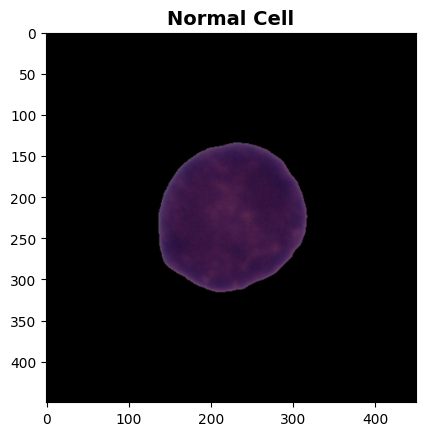

In [ ]:
img = mpimg.imread(normal_imgs[2]) # read image data
print(img.shape) # print shape of image data
plt.imshow(img) # display image data
plt.title("Normal Cell", fontsize=14, fontweight='bold')
plt.show()

(450, 450, 3)


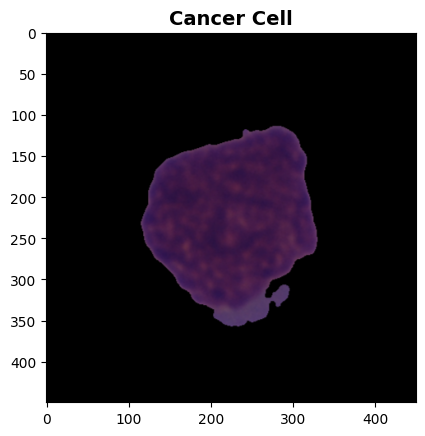

In [ ]:
img = mpimg.imread(cancer_imgs[2]) # read image data
print(img.shape) # print shape of image data
plt.imshow(img) # display image data
plt.title("Cancer Cell", fontsize=14, fontweight='bold')
plt.show()

## Image Preprocessing

In [ ]:
# standard shape of image
image_shape = (226,226,3)

In [ ]:
# import library for image manipulation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# set up generator for image manipulation to add diversity in dataset
train_image_gen = ImageDataGenerator(rotation_range=20, # rotate 20 degrees
                               width_shift_range=0.10, # shift width by max of 5%
                               height_shift_range=0.10, # shift height by max of 5%
                               rescale=1/255, # rescale image by normalzing
                               shear_range=0.1, # cutting part of image (max 10%)
                               zoom_range=0.1, # zoom by 10% max
                               horizontal_flip=True, # horizontal flip
                               fill_mode='nearest' # fill missing pixels with nearest filled value
                              )

val_image_gen = ImageDataGenerator(
                               rescale=1/255, # rescale image by normalzing
                               fill_mode='nearest' # fill missing pixels with nearest filled value
                              )

## Convolutional Neural Network Model for Image Classification

In [ ]:
# import relevant libraries from tensorflow for model construction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential() # make sequential model

# add convolutional layers with pooling layers (max pooling)
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output
model.add(Flatten())

# add batch normalization
model.add(BatchNormalization())

# add layer of neurons with 'relu' activation
model.add(Dense(128))
model.add(Activation('relu'))

# add dropout layer, rate=0.5
model.add(Dropout(0.6))

# final output neuron for prediction (cancer or not cancer) with 'sigmoid' activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model with 'ADAM' optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# prints out model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86528)          │       346,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,515,201 (43.93 MB)

 Trainable params: 11,342,145 (43.27 MB)

 Non-trainable params: 173,056 (676.00 KB)

In [ ]:
# early stopping to monitor validation loss for no improvement
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
batch_size = 32 # to train in batches

In [ ]:
# load images from 'fold_0' directory
train_image_gen_fold1 = train_image_gen.flow_from_directory(os.path.join(train_path,'fold_0'),
                                                      target_size=(224,224), # resize images to 224x224 pixels
                                                      color_mode='rgb', # load images in rgb color format
                                                      batch_size=batch_size, # number of images to return per batch
                                                      class_mode='binary') # set class labels as binary (0 or 1) for classification

Found 3537 images belonging to 2 classes.


In [ ]:
# load images from 'fold_1' directory
train_image_gen_fold2 = train_image_gen.flow_from_directory(os.path.join(train_path,'fold_1'),
                                                      target_size=(224,224),
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='binary')

Found 3591 images belonging to 2 classes.


In [ ]:
# load images from 'fold_2' directory
train_image_gen_fold3 = train_image_gen.flow_from_directory(os.path.join(train_path,'fold_2'),
                                                      target_size=(224,224),
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='binary')

Found 3553 images belonging to 2 classes.


In [ ]:
# generator to get validation images from directory and manipulate
val_image_gen = val_image_gen.flow_from_directory(val_path,
                                               target_size=(224,224),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 1867 images belonging to 2 classes.


In [ ]:
train_image_gen_fold1.class_indices # check labels of data

{'all': 0, 'hem': 1}

In [ ]:
val_image_gen.class_indices # check labels of data

{'all': 0, 'hem': 1}

In [ ]:
folds = [train_image_gen_fold1, train_image_gen_fold2, train_image_gen_fold3] # list of training data generators for each fold

# iterate through each fold with its index
for i, train_gen in enumerate(folds):
    print(f"Training on fold {i+1}...")
    results = model.fit(train_gen, # train model on current fold's training data
                        epochs=50, # train for 50 epochs
                        validation_data=val_image_gen, # use same validation generator across folds
                        callbacks=[early_stop]) # apply early stopping to avoid overfitting

Training on fold 1...
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1937s 17s/step - accuracy: 0.7337 - loss: 0.5712 - val_accuracy: 0.6529 - val_loss: 0.6449
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 78s 700ms/step - accuracy: 0.7940 - loss: 0.4812 - val_accuracy: 0.6529 - val_loss: 0.6284
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 65s 590ms/step - accuracy: 0.7977 - loss: 0.4667 - val_accuracy: 0.6529 - val_loss: 0.6273
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 62s 562ms/step - accuracy: 0.8197 - loss: 0.4316 - val_accuracy: 0.6984 - val_loss: 0.6061
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 63s 564ms/step - accuracy: 0.8310 - loss: 0.4136 - val_accuracy: 0.6524 - val_loss: 0.6197
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 62s 560ms/step - accuracy: 0.8303 - loss: 0.4104 - val_accuracy: 0.6760 - val_loss: 0.6467
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 566ms/step - accuracy: 0.8461 - loss: 0.3729 - val_accuracy: 0.6856 - val_loss: 1.0387
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 63s 567ms/step - accu

In [ ]:
# save model
model.save('cnn_unbalanced_model.keras')

In [ ]:
# save model weights
model.save_weights('cnn_unbalanced_weights.weights.h5')

In [ ]:
# import relevant library to store model history as json file
import json
with open('cnn_unbalanced_history.json', 'w') as f:
    json.dump(results.history, f)

In [ ]:
# save model architecture to JSON
with open("cnn_unbalanced_architecture.json", "w") as json_file:
    json_file.write(model.to_json())

## Model Evaluation

In [ ]:
# store results as dataframe
losses = pd.DataFrame(model.history.history)

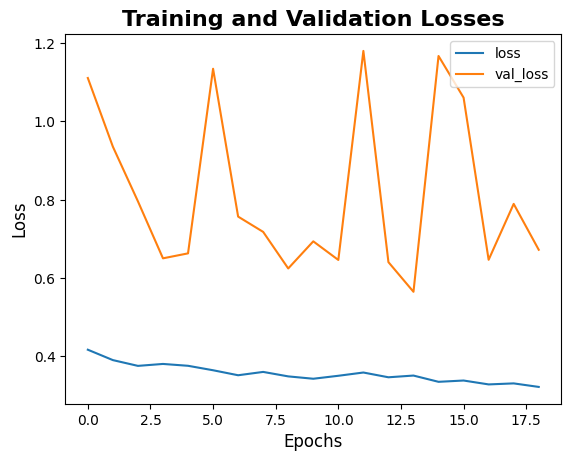

In [ ]:
# plot training and validation losses
ax = losses[['loss', 'val_loss']].plot()

# set title and labels
ax.set_title('Training and Validation Losses', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

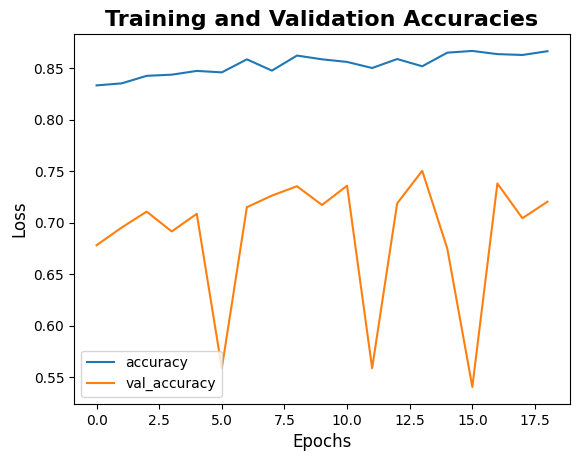

In [ ]:
# plot training and validation accuracies
ax = losses[['accuracy', 'val_accuracy']].plot()

# set title and labels
ax.set_title('Training and Validation Accuracies', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

In [ ]:
# metrics that were analyzed during fitting
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
# example evaluation on validation dataset to get those metrics
model.evaluate(val_image_gen)

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9008 - loss: 0.2844


[0.6723954677581787, 0.7204070687294006]

In [ ]:
# predict on validation dataset
pred_probabilities = model.predict(val_image_gen)

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step


In [ ]:
# classify predictions in binary method
predictions = pred_probabilities > 0.5
# predictions = (pred > 0.5).astype('int') # another way to do it

In [ ]:
val_image_gen.classes # check labels of data

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# import relevant libraries for classification metrics and quantitative analysis
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# print classification report to understand key metrics
print(classification_report(val_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1219
           1       0.79      0.27      0.40       648

    accuracy                           0.72      1867
   macro avg       0.75      0.61      0.61      1867
weighted avg       0.74      0.72      0.67      1867



In [ ]:
# print confusion matrix to investigate accurate predictions
print(confusion_matrix(val_image_gen.classes,predictions))

[[1172   47]
 [ 475  173]]


In [ ]:
# get confusion matrix
cm = confusion_matrix(val_image_gen.classes,predictions)

# extract True Positives, False Negatives, False Positives, True Negatives
TN, FP, FN, TP = cm.ravel()

# calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.2670
Specificity: 0.9614


AUC-ROC Score: 0.61420956


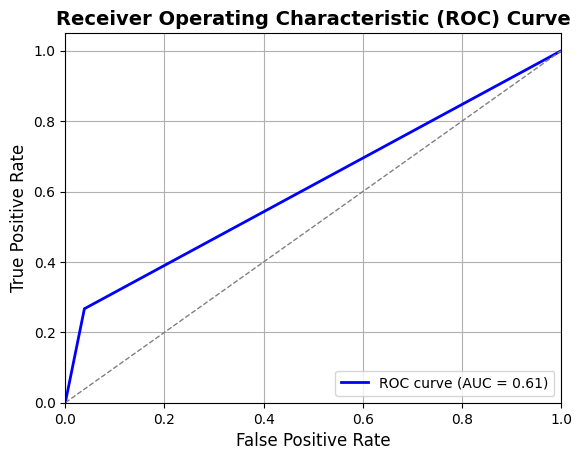

In [ ]:
# calculate AUC-ROC score
auc_roc = roc_auc_score(val_image_gen.classes,predictions)
print(f"AUC-ROC Score: {auc_roc:.8f}")

# compute ROC curve
fpr, tpr, thresholds = roc_curve(val_image_gen.classes,predictions)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14,fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Prediction on Testing Data

In [ ]:
# import relevant library for image analysis
from tensorflow.keras.preprocessing import image

In [ ]:
train_imgs = [] # list to store all training image names

for file in os.listdir(train_path): # parse through training directory and get all normal cell images
  for file2 in os.path.join(train_path,file,'hem'):
      train_imgs.append(os.path.join(train_path,file,'hem',file2))

In [ ]:
# load an example image - can change number
my_image = image.load_img(os.path.join(train_path,'fold_0','hem',normal_imgs[3]),target_size=image_shape)

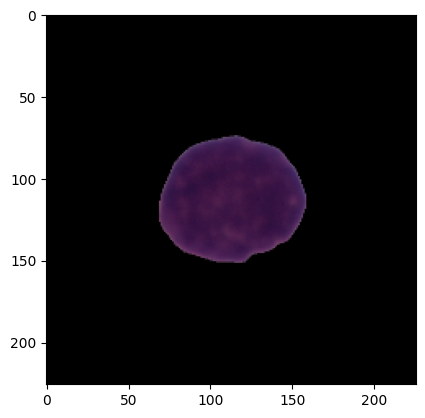

In [ ]:
# plot to see the image of cell
plt.imshow(my_image)

In [ ]:
my_image = image.img_to_array(my_image) # convert from image file to array for prediction

In [ ]:
my_image.shape # check shape of image array

(226, 226, 3)

In [ ]:
my_image.shape # recheck shape of image array

(226, 226, 3)

In [ ]:
my_image = tf.image.resize(my_image, (226, 226)) # resize to match expected input
my_image = tf.expand_dims(my_image, axis=0) # add batch dimension if missing

In [ ]:
model.predict(my_image) # make prediction on current selected cell

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.]], dtype=float32)

In [ ]:
train_image_gen_fold2.class_indices # definition of indices

{'all': 0, 'hem': 1}